Imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
% cd '/content/drive/My Drive/Colab Notebooks/c247'

from all_models import *
from all_solvers import *
from all_functions import *

import numpy as np
%matplotlib inline
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
from sklearn.model_selection import KFold
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
device = torch.device('cuda' if torch.cuda.is_available() else'cpu')

/content/drive/My Drive/Colab Notebooks/c247


Load Data

In [ ]:
# subject data
subject = 6
X_test, y_test, X_train_valid, y_train_valid = import_data_subject(subject)


# DeepConv, trialsize 900, stride 10

-- Fold [1/5] --
Epoch [10], Training loss [1.2680], Training accuracy [41.63%]
Epoch [10], Validation loss [1.6231], Validation accuracy [30.11%]
Epoch [20], Training loss [1.0356], Training accuracy [55.80%]
Epoch [20], Validation loss [2.0325], Validation accuracy [28.03%]
Epoch [30], Training loss [0.8882], Training accuracy [62.33%]
Epoch [30], Validation loss [2.3381], Validation accuracy [32.01%]
Epoch [40], Training loss [0.7737], Training accuracy [69.63%]
Epoch [40], Validation loss [2.7341], Validation accuracy [35.23%]
Epoch [50], Training loss [0.6484], Training accuracy [75.19%]
Epoch [50], Validation loss [3.0999], Validation accuracy [31.44%]
Epoch [60], Training loss [0.5843], Training accuracy [77.22%]
Epoch [60], Validation loss [3.2283], Validation accuracy [31.82%]
Epoch [70], Training loss [0.4585], Training accuracy [82.88%]
Epoch [70], Validation loss [3.4188], Validation accuracy [33.52%]
Epoch [80], Training loss [0.4009], Training accuracy [85.88%]
Epoch [80]

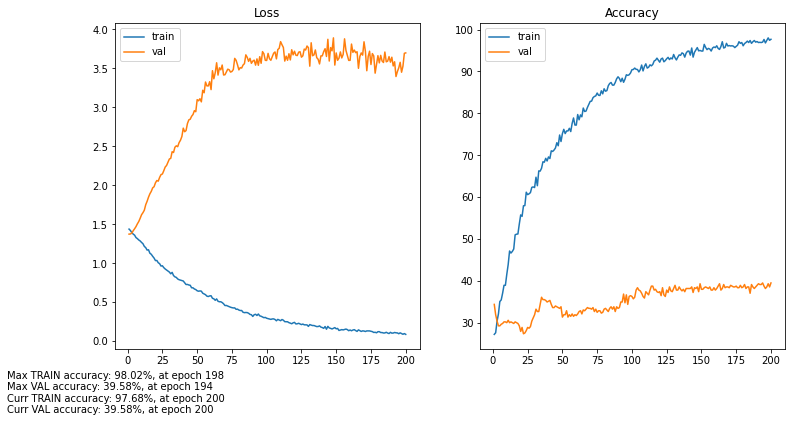

In [ ]:
# Set up cross validation folds, and average accuracy tracker
kf = KFold(n_splits=5, random_state=None, shuffle=True)
avg_accuracy=0
kcount = 1

for k_train_index, k_val_index in kf.split(X_train_valid):
  ## Only compute 1 fold due to computation time:
  if kcount==2:
    break
  ## Print fold
  print('-- Fold [{}/5] --'.format(kcount))

  ## Create this fold's dataloader
  SEGMENT = True
  VOTE = False
  window_width = 900
  stride = 10
  num_slices = int((1000-window_width)/stride+1)

  dataloaders = make_dataloaders(k_train_index, k_val_index, X_train_valid, y_train_valid, X_test, y_test, 
                                 cut=SEGMENT, window_width=window_width, stride=stride, num_slices=num_slices)
  
  ## Create model, hyperpatameters, optimizer, loss function 
  weight_decay = 0.001
  model = DeepConv(in_channels=1, classes=4, cnn_drop=0.5, trial_length=window_width).to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4, weight_decay=weight_decay)
  loss_fn = nn.CrossEntropyLoss()
  num_epochs = 200

  ## Start training/validating/training
  # set up per epoch accuracy and loss trackers
  loss_tracker = {'train':[], 'val':[]}
  accuracy_tracker = {'train':[], 'val':[]}
  best_model_params = [0, model]

  for epoch in range(num_epochs): 
    logs = {}
    # train on training samples
    model, epoch_loss_avg, epoch_accuracy = train(model, optimizer, loss_fn, dataloaders, device, epoch)
    loss_tracker['train'].append(epoch_loss_avg)
    accuracy_tracker['train'].append(epoch_accuracy)

    # evalutate on validation samples 
    epoch_loss_avg, epoch_accuracy, best_model_params = validate(model, optimizer, loss_fn, dataloaders, device, epoch, best_model_params)
    loss_tracker['val'].append(epoch_loss_avg)
    accuracy_tracker['val'].append(epoch_accuracy)

  # plot train/validation graph
  make_plot(num_epochs, loss_tracker, accuracy_tracker, saveplot=False)
  # get model weights from the epoch with the highest validation accuracy
  _, final_best_model = best_model_params
  thisacc = finaltest(final_best_model, dataloaders, device)
  print('Test accuracy from the best model during fold [{}] is: [{:.2f}%]'.format(kcount, thisacc))
  kcount += 1
  avg_accuracy += thisacc

print('Average test accuracy of 5-fold validation: [{:.2f}]'.format(avg_accuracy/5))

# DeepConv2, trialsize 900, stride 10

-- Fold [1/5] --
Epoch [10], Training loss [1.3795], Training accuracy [29.40%]
Epoch [10], Validation loss [1.3970], Validation accuracy [25.00%]
Epoch [20], Training loss [1.3241], Training accuracy [40.14%]
Epoch [20], Validation loss [1.4312], Validation accuracy [25.00%]
Epoch [30], Training loss [1.1633], Training accuracy [45.74%]
Epoch [30], Validation loss [1.5078], Validation accuracy [20.83%]
Epoch [40], Training loss [1.0160], Training accuracy [51.69%]
Epoch [40], Validation loss [1.5593], Validation accuracy [20.83%]
Epoch [50], Training loss [0.9066], Training accuracy [59.04%]
Epoch [50], Validation loss [1.6223], Validation accuracy [24.05%]
Epoch [60], Training loss [0.8319], Training accuracy [63.93%]
Epoch [60], Validation loss [1.7145], Validation accuracy [27.08%]
Epoch [70], Training loss [0.7590], Training accuracy [67.75%]
Epoch [70], Validation loss [1.8494], Validation accuracy [27.08%]
Epoch [80], Training loss [0.7029], Training accuracy [71.47%]
Epoch [80]

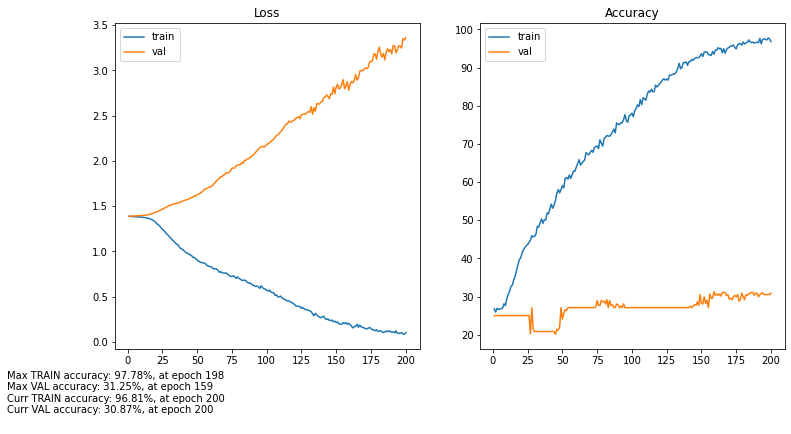

In [ ]:
# Set up cross validation folds, and average accuracy tracker
kf = KFold(n_splits=5, random_state=None, shuffle=True)
avg_accuracy=0
kcount = 1

for k_train_index, k_val_index in kf.split(X_train_valid):
  ## Only compute 1 fold due to computation time:
  if kcount==2:
    break
  ## Print fold
  print('-- Fold [{}/5] --'.format(kcount))

  ## Create this fold's dataloader
  SEGMENT = True
  VOTE = False
  window_width = 900
  stride = 10
  num_slices = int((1000-window_width)/stride+1)

  dataloaders = make_dataloaders(k_train_index, k_val_index, X_train_valid, y_train_valid, X_test, y_test, 
                                 cut=SEGMENT, window_width=window_width, stride=stride, num_slices=num_slices)
  
  ## Create model, hyperpatameters, optimizer, loss function 
  weight_decay = 0.001
  model = DeepConv2(in_channels=1, classes=4, cnn_drop=0.5).to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4, weight_decay=weight_decay)
  loss_fn = nn.CrossEntropyLoss()
  num_epochs = 200

  ## Start training/validating/training
  # set up per epoch accuracy and loss trackers
  loss_tracker = {'train':[], 'val':[]}
  accuracy_tracker = {'train':[], 'val':[]}
  best_model_params = [0, model]

  for epoch in range(num_epochs): 
    logs = {}
    # train on training samples
    model, epoch_loss_avg, epoch_accuracy = train(model, optimizer, loss_fn, dataloaders, device, epoch)
    loss_tracker['train'].append(epoch_loss_avg)
    accuracy_tracker['train'].append(epoch_accuracy)

    # evalutate on validation samples 
    epoch_loss_avg, epoch_accuracy, best_model_params = validate(model, optimizer, loss_fn, dataloaders, device, epoch, best_model_params)
    loss_tracker['val'].append(epoch_loss_avg)
    accuracy_tracker['val'].append(epoch_accuracy)

  # plot train/validation graph
  make_plot(num_epochs, loss_tracker, accuracy_tracker, saveplot=False)
  # get model weights from the epoch with the highest validation accuracy
  _, final_best_model = best_model_params
  thisacc = finaltest(final_best_model, dataloaders, device)
  print('Test accuracy from the best model during fold [{}] is: [{:.2f}%]'.format(kcount, thisacc))
  kcount += 1
  avg_accuracy += thisacc

print('Average test accuracy of 5-fold validation: [{:.2f}]'.format(avg_accuracy/5))

# Conv1, trialsize 900, stride 10

-- Fold [1/5] --
Epoch [10], Training loss [1.2861], Training accuracy [40.43%]
Epoch [10], Validation loss [1.5352], Validation accuracy [23.48%]
Epoch [20], Training loss [1.1234], Training accuracy [51.74%]
Epoch [20], Validation loss [1.8089], Validation accuracy [23.30%]
Epoch [30], Training loss [0.9611], Training accuracy [59.19%]
Epoch [30], Validation loss [1.9428], Validation accuracy [20.27%]
Epoch [40], Training loss [0.8357], Training accuracy [66.54%]
Epoch [40], Validation loss [1.9359], Validation accuracy [24.43%]
Epoch [50], Training loss [0.7197], Training accuracy [72.00%]
Epoch [50], Validation loss [2.0203], Validation accuracy [25.19%]
Epoch [60], Training loss [0.5741], Training accuracy [78.68%]
Epoch [60], Validation loss [2.1803], Validation accuracy [24.05%]
Epoch [70], Training loss [0.4733], Training accuracy [83.08%]
Epoch [70], Validation loss [2.3214], Validation accuracy [26.70%]
Epoch [80], Training loss [0.4039], Training accuracy [85.88%]
Epoch [80]

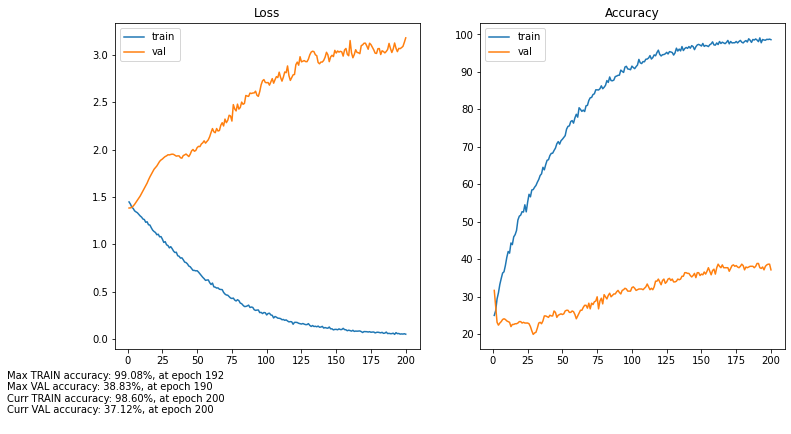

In [ ]:
# Set up cross validation folds, and average accuracy tracker
kf = KFold(n_splits=5, random_state=None, shuffle=True)
avg_accuracy=0
kcount = 1

for k_train_index, k_val_index in kf.split(X_train_valid):
  ## Only compute 1 fold due to computation time:
  if kcount==2:
    break
  ## Print fold
  print('-- Fold [{}/5] --'.format(kcount))

  ## Create this fold's dataloader
  SEGMENT = True
  VOTE = False
  window_width = 900
  stride = 10
  num_slices = int((1000-window_width)/stride+1)

  dataloaders = make_dataloaders(k_train_index, k_val_index, X_train_valid, y_train_valid, X_test, y_test, 
                                 cut=SEGMENT, window_width=window_width, stride=stride, num_slices=num_slices)
  
  ## Create model, hyperpatameters, optimizer, loss function 
  weight_decay = 0.001
  model = Conv1(dropout=0.5, trial_length=window_width).to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4, weight_decay=weight_decay)
  loss_fn = nn.CrossEntropyLoss()
  num_epochs = 200

  ## Start training/validating/training
  # set up per epoch accuracy and loss trackers
  loss_tracker = {'train':[], 'val':[]}
  accuracy_tracker = {'train':[], 'val':[]}
  best_model_params = [0, model]

  for epoch in range(num_epochs): 
    logs = {}
    # train on training samples
    model, epoch_loss_avg, epoch_accuracy = train(model, optimizer, loss_fn, dataloaders, device, epoch)
    loss_tracker['train'].append(epoch_loss_avg)
    accuracy_tracker['train'].append(epoch_accuracy)

    # evalutate on validation samples 
    epoch_loss_avg, epoch_accuracy, best_model_params = validate(model, optimizer, loss_fn, dataloaders, device, epoch, best_model_params)
    loss_tracker['val'].append(epoch_loss_avg)
    accuracy_tracker['val'].append(epoch_accuracy)

  # plot train/validation graph
  make_plot(num_epochs, loss_tracker, accuracy_tracker, saveplot=False)
  # get model weights from the epoch with the highest validation accuracy
  _, final_best_model = best_model_params
  thisacc = finaltest(final_best_model, dataloaders, device)
  print('Test accuracy from the best model during fold [{}] is: [{:.2f}%]'.format(kcount, thisacc))
  kcount += 1
  avg_accuracy += thisacc

print('Average test accuracy of 5-fold validation: [{:.2f}]'.format(avg_accuracy/5))

# Conv2, trialsize 900, stride 10

-- Fold [1/5] --
Epoch [10], Training loss [1.3804], Training accuracy [29.11%]
Epoch [10], Validation loss [1.3877], Validation accuracy [28.60%]
Epoch [20], Training loss [1.3677], Training accuracy [32.01%]
Epoch [20], Validation loss [1.3864], Validation accuracy [20.08%]
Epoch [30], Training loss [1.3287], Training accuracy [36.32%]
Epoch [30], Validation loss [1.3801], Validation accuracy [17.42%]
Epoch [40], Training loss [1.2439], Training accuracy [44.39%]
Epoch [40], Validation loss [1.3661], Validation accuracy [28.41%]
Epoch [50], Training loss [1.1341], Training accuracy [50.10%]
Epoch [50], Validation loss [1.3862], Validation accuracy [31.82%]
Epoch [60], Training loss [1.0012], Training accuracy [56.58%]
Epoch [60], Validation loss [1.3359], Validation accuracy [39.20%]
Epoch [70], Training loss [0.9125], Training accuracy [61.65%]
Epoch [70], Validation loss [1.3453], Validation accuracy [39.96%]
Epoch [80], Training loss [0.8398], Training accuracy [65.33%]
Epoch [80]

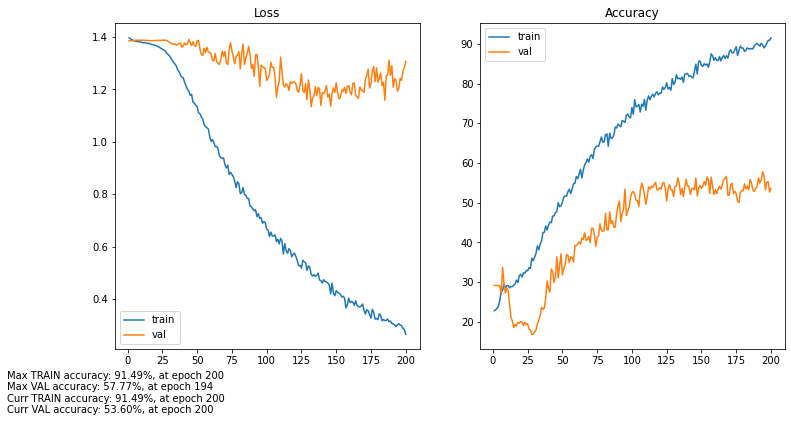

In [ ]:
# Set up cross validation folds, and average accuracy tracker
kf = KFold(n_splits=5, random_state=None, shuffle=True)
avg_accuracy=0
kcount = 1

for k_train_index, k_val_index in kf.split(X_train_valid):
  ## Only compute 1 fold due to computation time:
  if kcount==2:
    break
  ## Print fold
  print('-- Fold [{}/5] --'.format(kcount))

  ## Create this fold's dataloader
  SEGMENT = True
  VOTE = False
  window_width = 900
  stride = 10
  num_slices = int((1000-window_width)/stride+1)

  dataloaders = make_dataloaders(k_train_index, k_val_index, X_train_valid, y_train_valid, X_test, y_test, 
                                 cut=SEGMENT, window_width=window_width, stride=stride, num_slices=num_slices)
  
  ## Create model, hyperpatameters, optimizer, loss function 
  weight_decay = 0.001
  model = Conv2(dropout=0.5).to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4, weight_decay=weight_decay)
  loss_fn = nn.CrossEntropyLoss()
  num_epochs = 200

  ## Start training/validating/training
  # set up per epoch accuracy and loss trackers
  loss_tracker = {'train':[], 'val':[]}
  accuracy_tracker = {'train':[], 'val':[]}
  best_model_params = [0, model]

  for epoch in range(num_epochs): 
    logs = {}
    # train on training samples
    model, epoch_loss_avg, epoch_accuracy = train(model, optimizer, loss_fn, dataloaders, device, epoch)
    loss_tracker['train'].append(epoch_loss_avg)
    accuracy_tracker['train'].append(epoch_accuracy)

    # evalutate on validation samples 
    epoch_loss_avg, epoch_accuracy, best_model_params = validate(model, optimizer, loss_fn, dataloaders, device, epoch, best_model_params)
    loss_tracker['val'].append(epoch_loss_avg)
    accuracy_tracker['val'].append(epoch_accuracy)

  # plot train/validation graph
  make_plot(num_epochs, loss_tracker, accuracy_tracker, saveplot=False)
  # get model weights from the epoch with the highest validation accuracy
  _, final_best_model = best_model_params
  thisacc = finaltest(final_best_model, dataloaders, device)
  print('Test accuracy from the best model during fold [{}] is: [{:.2f}%]'.format(kcount, thisacc))
  kcount += 1
  avg_accuracy += thisacc

print('Average test accuracy of 5-fold validation: [{:.2f}]'.format(avg_accuracy/5))